In [99]:
import random
import math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import os
import sys
sys.path.append(os.path.abspath('..'))
from figures.plots import show_embeddings
from models.model1 import Seq2SeqAutoencoder

import matplotlib.pyplot as plt

# import warnings
# warnings.filterwarnings('ignore')

In [213]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        # Create a long enough "pe" matrix of positional encodings
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encodings to the input tensor
        x = x + self.pe[:x.size(0), :]
        return x

In [249]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.01, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.tensor) -> torch.tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x.permute(1, 0, 2)
        x = x + self.pe[:x.size(0)]
        return self.dropout(x).permute(1, 0, 2)

In [250]:
pos_encoder = PositionalEncoding(6)

In [251]:
x = torch.zeros(10, 32, 6)  # example input tensor (sequence length, batch size, embedding size)
x[0, -1, 0] = 1
x = pos_encoder(x)

In [252]:
x[0, -1]

tensor([0.6020, 0.9240, 1.0013, 0.1329, 0.0674, 1.0078])

In [230]:
x[-1, 0]

tensor([ 0.4121, -0.9111,  0.4057,  0.9140,  0.0194,  0.9998])

In [304]:
class PositionalAutoencoder(nn.Module):
    """
    Модель автоэнкодера. Декодер работает по принципу копирования
    выхода из энкодера.
    """

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(PositionalAutoencoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.t_encoder = PositionalEncoding(hidden_dim)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hidden, _) = self.encoder(x)
        
        cell = torch.zeros(hidden.shape)
        t_vectors = self.t_encoder(torch.zeros((*x.shape[:2], self.hidden_dim)))
        
        output, _ = self.decoder(t_vectors, (hidden, cell))
        output = self.fc(output)
        
        return output

In [305]:
def random_batch():
    a, b = 10, 50
    m = 10000                 # number of matrix elements
    n = random.randint(a, b)  # number of points
    batch = []
    batch_size = int(m / n)
    for _ in range(batch_size):
        shift = random.uniform(0, torch.pi)
        sin_size = random.uniform(1, 10)
        x = torch.linspace(0, torch.pi * sin_size, n) + shift
        y = torch.sin(x)
        item = y.unsqueeze(-1)
        batch.append(item)
    return torch.stack(batch)

In [306]:
X = random_batch()
X.shape

torch.Size([384, 26, 1])

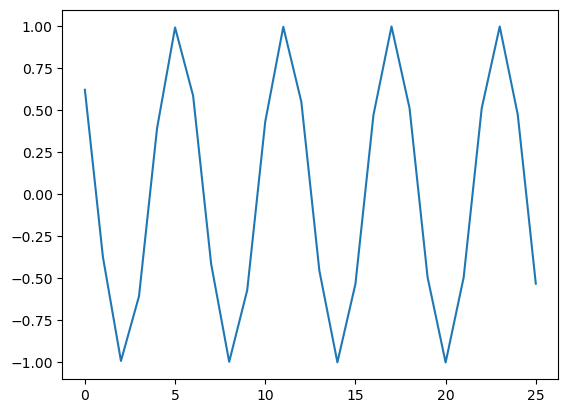

In [307]:
plt.plot(X[35, :, 0])

In [308]:
model = PositionalAutoencoder(1, 16, 1)

In [311]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [312]:
accumulated_loss = []
for i in range(100000):
    X = random_batch()
    output = model(X)
    loss = criterion(output, X)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    accumulated_loss.append(loss.item())
    if i % 1000 == 0 and i != 0:
        print(np.mean(accumulated_loss))
        accumulated_loss = []

0.47473727165164054
0.44726871103048327
0.4101033593714237
0.34533726085722444
0.32089522981643676
0.29571500362455844
0.27617654816806314
0.2636911304146051
0.2583156133443117
0.24491671282052993
0.24004756513237954
0.23335004368424417


KeyboardInterrupt: 

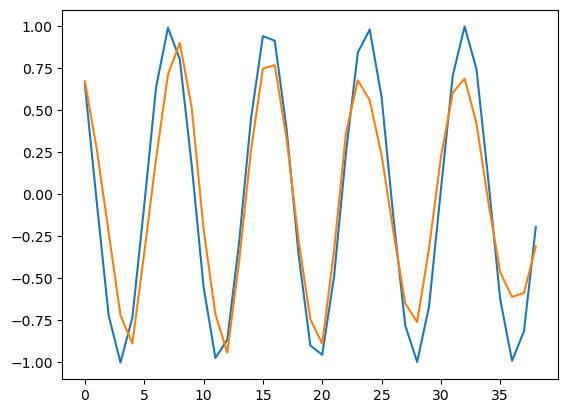

In [322]:
i = 50
plt.plot(X[i, :, 0])
plt.plot(output[i, :, 0].detach())